In [17]:
import numpy as np
import pandas as pd;
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### MATH 189 Winter 2024

## Dropout Analytics: Understanding Key Drivers for Dropout Students
##### Leena Kang, Samuel Mai, Krystal Qiu, Ethan Lin, Mackenzie May

### Introduction (Ethan) 

### The Dataset (Ethan)

### Data Cleaning + Exploratory Data Analysis (Leena)

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 

df1_raw = X.assign(Target=y.get('Target'))

# making a copy to use 
df1 = df1_raw.copy(deep=True)

df1_raw.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
df1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

> ### Data Cleaning and Preprocessing

In [6]:
df1_raw.isnull().sum() # no null values

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

> ##### We removed columns related to appliction as it does not have much relation with our research project, and the meaning behind each category was left a little unclear.

In [7]:
# removing columns 
df1 = df1.drop(columns=['Application mode', 'Application order'])

> ##### The dataset is made up of binary and multiclass data represented as integers. For clarity, we referred to its documentation and converted integer values to its corresponding description (if applicable).

In [8]:
# converting binary data

binary_cols = ['Daytime/evening attendance','Displaced', 'Educational special needs', 'Debtor',
               'Tuition fees up to date', 'Scholarship holder',]

def get_attendance(val):
    if val == 1:
        return 'Day'
    else:
        return 'Evening'

def get_gender(val):
    if val == 1:
        return 'Male'
    else:
        return 'Female'

df1 = df1.assign(isDisplaced = (df1.get('Displaced') == 1))
df1 = df1.assign(hasSpecialNeeds = (df1.get('Educational special needs') == 1))
df1 = df1.assign(tuitionToDate = (df1.get('Tuition fees up to date') == 1))
df1 = df1.assign(hasScholarship = (df1.get('Scholarship holder') == 1))
df1 = df1.assign(isDebtor = (df1.get('Debtor') == 1))
df1['Gender'] = df1.get('Gender').apply(get_gender)
df1['AttendanceTime'] = df1.get('Daytime/evening attendance').apply(get_attendance)

df1 =df1.drop(columns=binary_cols)

In [9]:
# sanity check 
print(df1_raw['Displaced'].value_counts())
df1['isDisplaced'].value_counts()

1    2426
0    1998
Name: Displaced, dtype: int64


True     2426
False    1998
Name: isDisplaced, dtype: int64

> ##### Directly converting integer values to its corresponding description

In [10]:
def get_marital_status(int):
    marital_status = {
        1:'Single',
        2:'Married',
        3:'Widower',
        4:'Divorced',
        5:'Facto Union',
        6:'Legally Separated'
    }
    return marital_status[int]

def get_course(int):
    courses = {
        33: 'Biofuel Production Technologies',
        171: 'Animation and Multimedia Design',
        8014: 'Social Service (evening attendance)',
        9003: 'Agronomy',
        9070: 'Communication Design', 
        9085: 'Veterinary Nursing', 
        9119: 'Informatics Engineering', 
        9130: 'Equinculture', 
        9147: 'Management', 
        9238: 'Social Service', 
        9254: 'Tourism', 
        9500: 'Nursing', 
        9556: 'Oral Hygiene', 
        9670: 'Advertising and Marketing Management', 
        9773: 'Journalism and Communication', 
        9853: 'Basic Education', 
        9991: 'Management (evening attendance)'
    }
    return courses[int]

def get_nationality(int):
    nationality = {
        1 : 'Portuguese',
        2 : 'German',
        6 : 'Spanish',
        11 : 'Italian',
        13 :'Dutch',
        14 : 'English',
        17 : 'Lithuanian',
        21 : 'Angolan',
        22 : 'Cape Verdean',
        24 : 'Guinean',
        25 : 'Mozambican',
        26 : 'Santomean',
        32 : 'Turkish',
        41 : 'Brazilian',
        62 : 'Romanian',
        100 : 'Moldova (Republic of)',
        101 : 'Mexican',
        103 : 'Ukrainian',
        105 : 'Russian',
        108 : 'Cuban',
        109 : 'Colombian'
    }
    return nationality[int]


df1['Marital Status'] = df1.get('Marital Status').apply(get_marital_status)
df1['Course'] = df1.get('Course').apply(get_course)
df1['Nationality'] = df1.get('Nacionality').apply(get_nationality)
df1 = df1.drop(columns=['Nacionality'])

In [11]:
# sanity check 
print(df1_raw['Marital Status'].value_counts())
df1['Marital Status'].value_counts()

1    3919
2     379
4      91
5      25
6       6
3       4
Name: Marital Status, dtype: int64


Single               3919
Married               379
Divorced               91
Facto Union            25
Legally Separated       6
Widower                 4
Name: Marital Status, dtype: int64

##### Columns associated with **education level** and contains many specific cateogories that can be arguably grouped together (some which only has one count). Below details how the data for these columns are categorized: 

> `Previous qualification`:
>
> >**Below secondary** - did not complete high school
> >
> >**Secondary** - completed high school or equivalent,
> >
> >**Higher** - bachelor's (or equivalent) or above
> >
>
> `Mother's qualification` and `Father's qualification`:
>
>> **Basic** - below high school education
>>
>>**Secondary** - completed high school or equivalent
>>
>>**Higher** - bachelor's (or equivalent) or above
>>
>>
>>**Unknown** - information unknown

In [12]:
def get_prev_qual(int):
    higher_education = [2,3,4,5,6,40,42,43,39]
    
    if int == 1:
        return 'Secondary'
    elif int in higher_education:
        return 'Higher'
    else:
        return 'Below secondary'

def get_mother_qual(int):
    basic_education = [9,10,11,12,14,18,19,26,27,29,30,35,36,37,38]
    higher_education = [2,3,4,5,6,22,39,40,41,42,43,44]
    
    if int == 1:
        return 'Secondary'
    elif int in basic_education:
        return 'Basic'
    elif int in higher_education:
        return 'Higher'
    else:
        return 'Unknown'

def get_father_qual(int):
    basic_education = [9,10,11,12,13,14,18,19,20,25,26,27,29,30,31,35,36,37,38]
    higher_education = [2,3,4,5,6,22,33,39,40,31,32,43,44]
    
    if int == 1:
        return 'Secondary'
    elif int in basic_education:
        return 'Basic'
    elif int in higher_education:
        return 'Higher'
    else:
        return 'Unknown'

df1['Previous qualification'] = df1.get('Previous qualification').apply(get_prev_qual)
df1['Mother\'s qualification'] = df1.get('Mother\'s qualification').apply(get_mother_qual)
df1['Father\'s qualification'] = df1.get('Father\'s qualification').apply(get_father_qual)

#### Target 
##### The target variable consists of 3 categories (graduate, enrolled, droupout), but since this research is primarily concerned with whether students dropped out of school or not, we combined 'graduate' and 'erolled' into one category 

In [13]:
df1_raw['Target'].value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

In [14]:
# Combining 'Graduate' and 'Enrolled' into one 

def get_target(y):
    if (y == 'Graduate') or (y == 'Enrolled'):
        return 'Graduate/Enrolled'
    else:
        return 'Dropout'
        
df1['Target'] = df1.get('Target').apply(get_target)

> ### Exploratory Data Analysis and Visualization

In [15]:
df1['Target'].value_counts()

Graduate/Enrolled    3003
Dropout              1421
Name: Target, dtype: int64

**Note that there is almost twice as many students who have graduated/enrolled, as expeccted.**

### Multiclass Data and Target

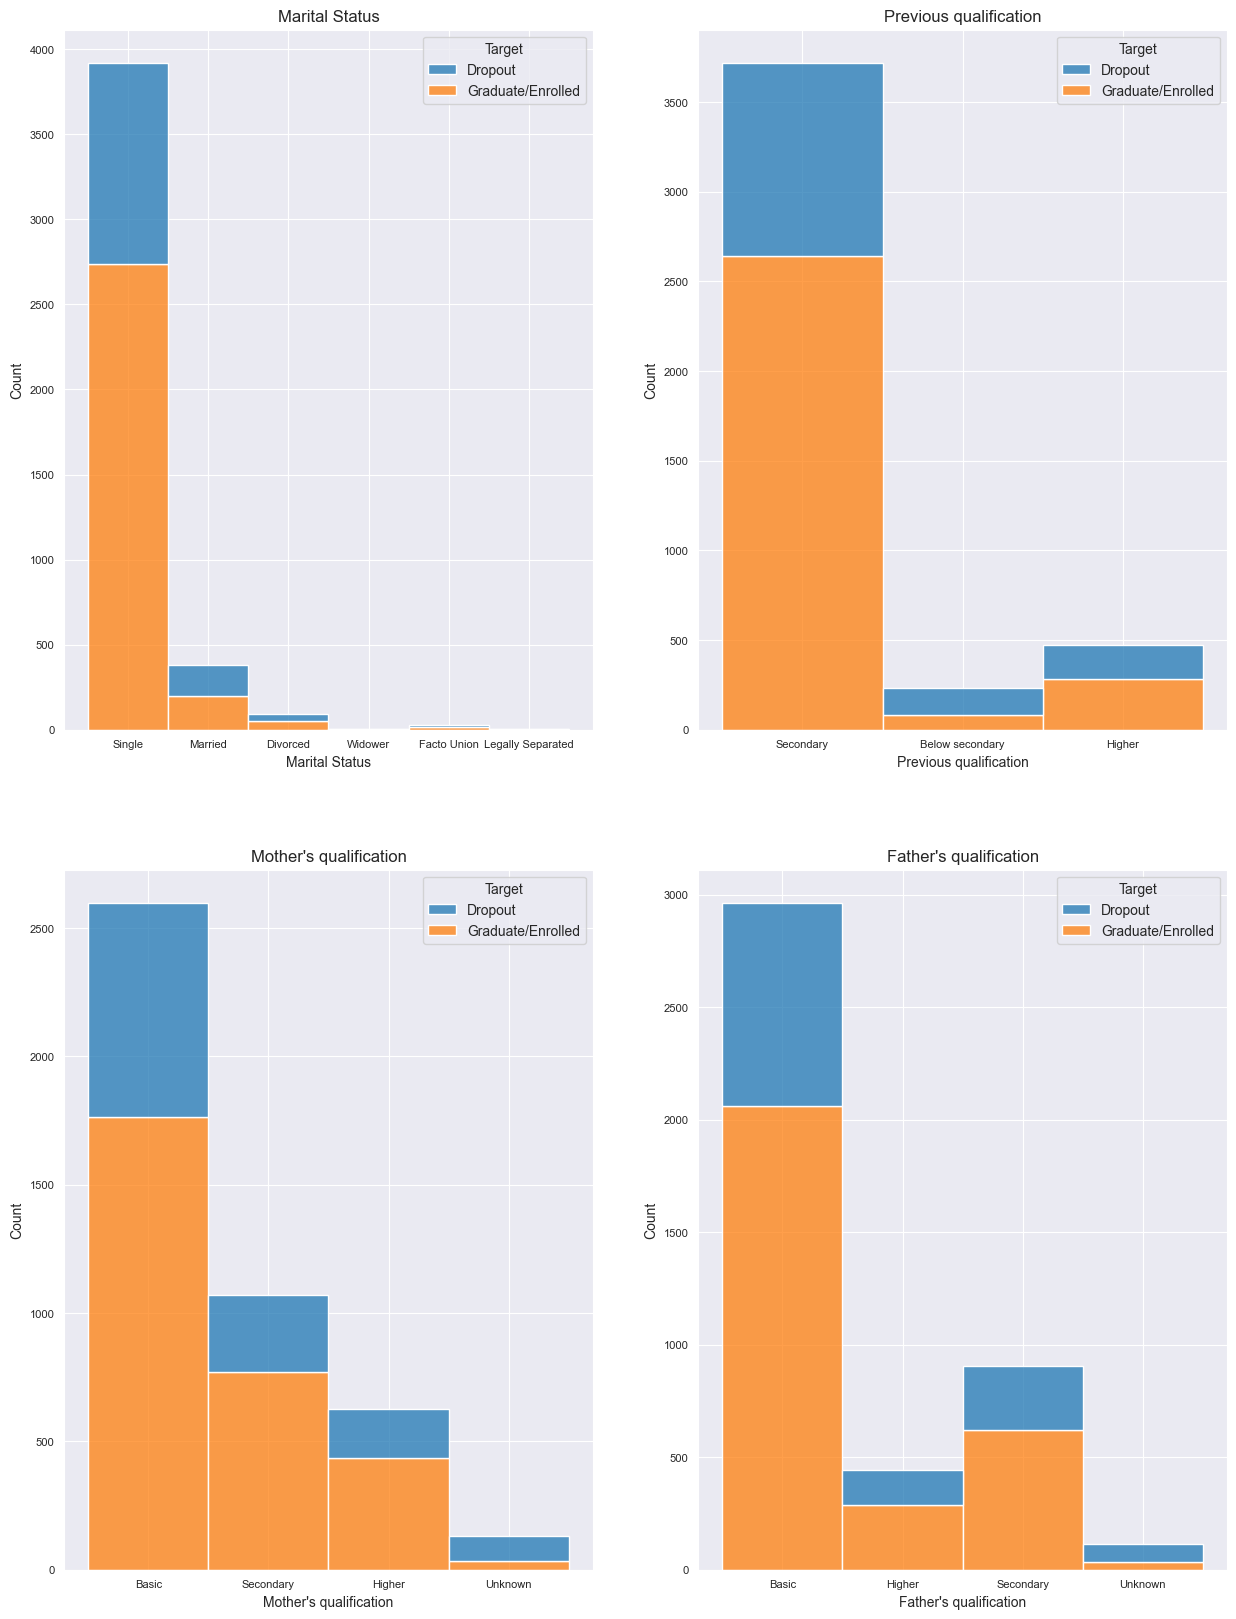

In [18]:
sns.set_style('darkgrid')

cols = ['Marital Status', 'Previous qualification', 'Mother\'s qualification', 'Father\'s qualification']

pos = 1
plt.figure(figsize=(15,20))
for col in cols:
    plt.subplot(2,2,pos)
    b = sns.histplot(data=df1, x=col, hue='Target', multiple = 'stack')
    b.tick_params(labelsize=8)
    plt.title(f"{col}")
    pos += 1

#### Marital Status and Previous Qualificaion: Relative Frequencies

> Due to the imbalance of data, visualizing the relative frequencies of dropout and graduate/enrolled students can provide a clearer picture of potentially significant differences.

In [19]:
# creating dataframe with relative frequencies for each target 
df1_grad = df1[df1['Target'] == 'Graduate/Enrolled']
df1_drop = df1[df1['Target'] == 'Dropout']

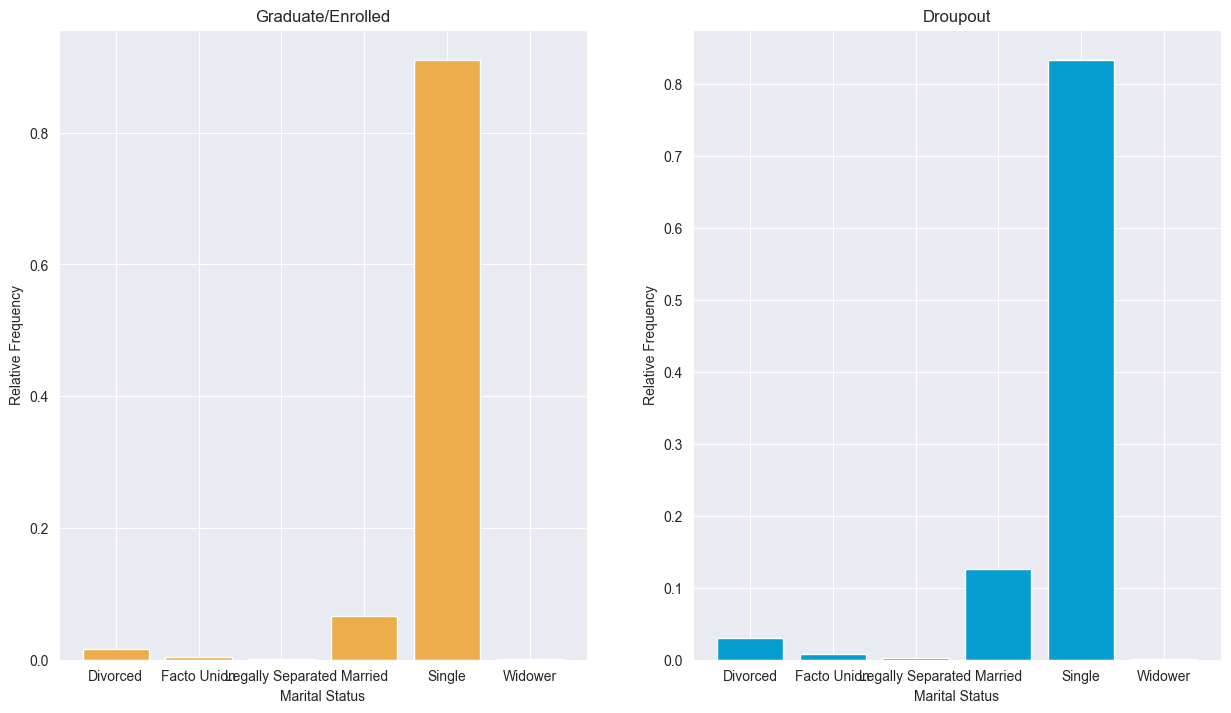

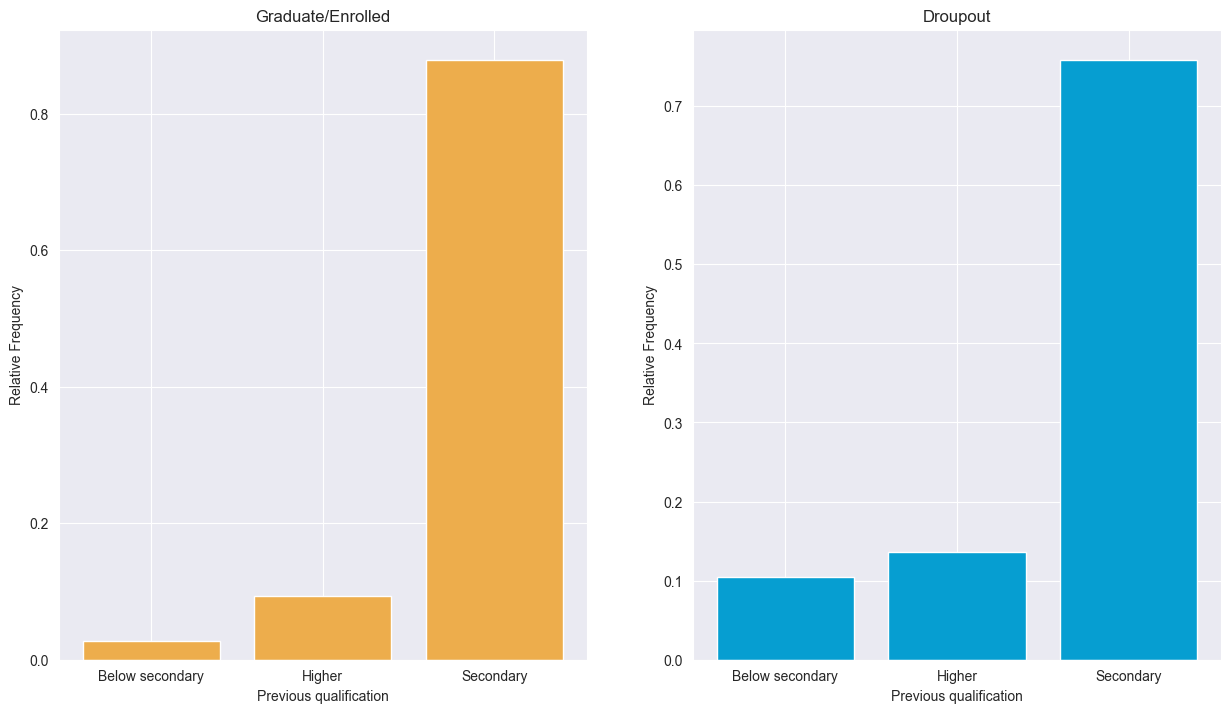

In [20]:
cols = ['Marital Status', 'Previous qualification']

pos = 1
for col in cols:
    plt.figure(figsize=(15,18))
    
    #creating DF with col, relative frequency for GRADUATE/ENROLLED
    grad_relfreq = df1_grad.groupby(col).count().reset_index()
    grad_relfreq = grad_relfreq.assign(Relative_Frequency = grad_relfreq.get('Course') / df1_grad.shape[0])
    grad_relfreq = grad_relfreq[[col, 'Relative_Frequency']]
    #convert bool val to String object
    grad_relfreq[col] = grad_relfreq.get(col).astype(str)

    #plot
    plt.subplot(2,2,pos)
    plt.bar(data=grad_relfreq, x=col, height='Relative_Frequency', color='#edad4c')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title('Graduate/Enrolled')

    #increment 
    pos += 1

    #creating DF with col, relative frequency for DROPOut
    drop_relfreq = df1_drop.groupby(col).count().reset_index()
    drop_relfreq = drop_relfreq.assign(Relative_Frequency = drop_relfreq.get('Course') / df1_drop.shape[0])
    drop_relfreq = drop_relfreq[[col, 'Relative_Frequency']]
    drop_relfreq[col] = drop_relfreq.get(col).astype(str)

    #plot
    plt.subplot(2,2,pos)
    plt.bar(data=drop_relfreq, x=col, height='Relative_Frequency', color='#069ed1')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title('Droupout')
    
    plt.show()

    #increment 
    pos += 1

> #### Key Observations

- A **larger proportion** of dropout students are **married** or **divorced**
- A **larger proportion** of dropout students did not complete high school (**_i.e., Below secondary_**)

In [21]:
# storing relative frequencies 

    #marital_status
marital_status = pd.crosstab(df1['Target'], df1['Marital Status'])
marital_status_relfreq_drop = marital_status.loc['Dropout'] / df1_drop.shape[0]
marital_status_relfreq_grad = marital_status.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #previous qualification
prev_qual = pd.crosstab(df1['Target'], df1['Previous qualification'])
prev_qual_relfreq_drop = prev_qual.loc['Dropout'] / df1_drop.shape[0]
prev_qual_relfreq_grad = prev_qual.loc['Graduate/Enrolled'] / df1_grad.shape[0]

### Binary Data and Target

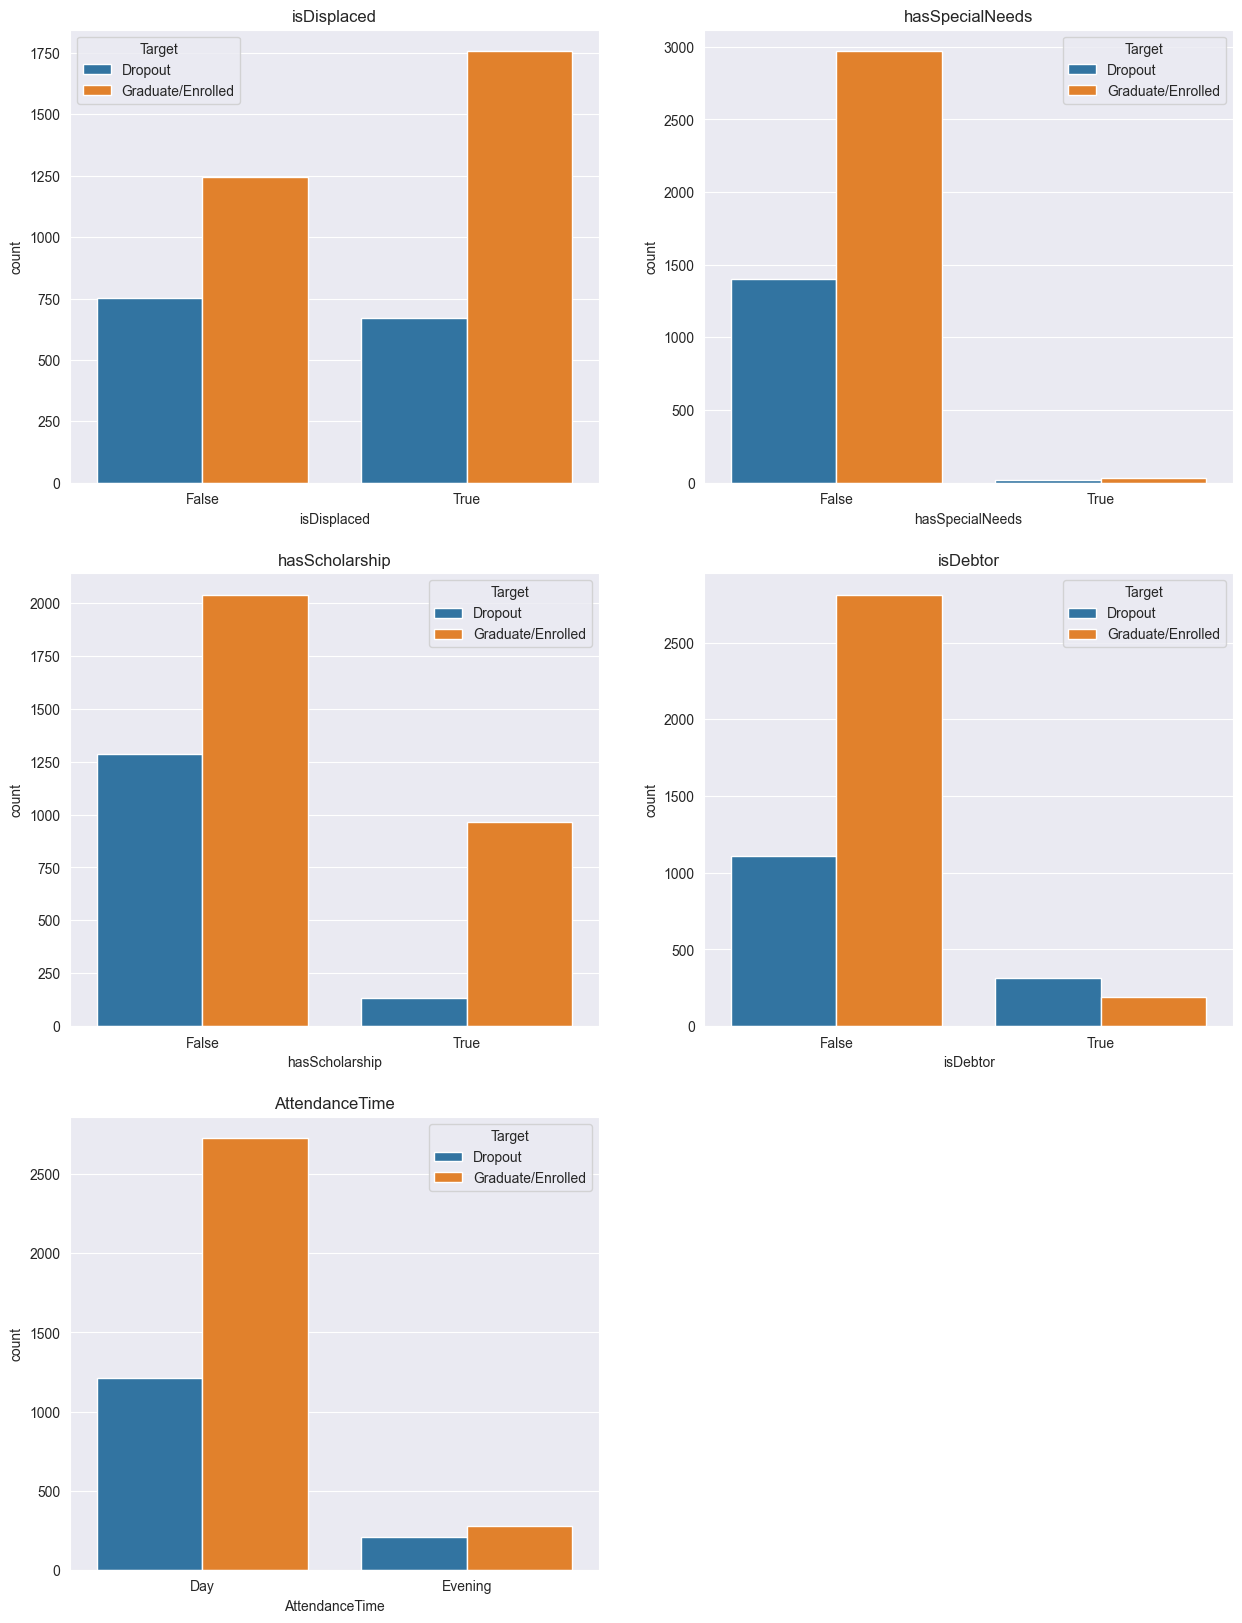

In [22]:
cols = ['isDisplaced', 'hasSpecialNeeds', 'hasScholarship', 'isDebtor', 'AttendanceTime']

pos = 1
plt.figure(figsize=(15,20))
for col in cols:
    plt.subplot(3,2,pos)
    b = sns.countplot(data=df1, x=col, hue='Target')
    # b.tick_params(labelsize=8)
    plt.title(f"{col}")
    pos += 1

#### Relative Frequencies and the Target
> Similarly, due to the imbalance of data, rather than plotting the counts of each feature, it's worth graphing the relative frequencies of each feature for each target variable. 

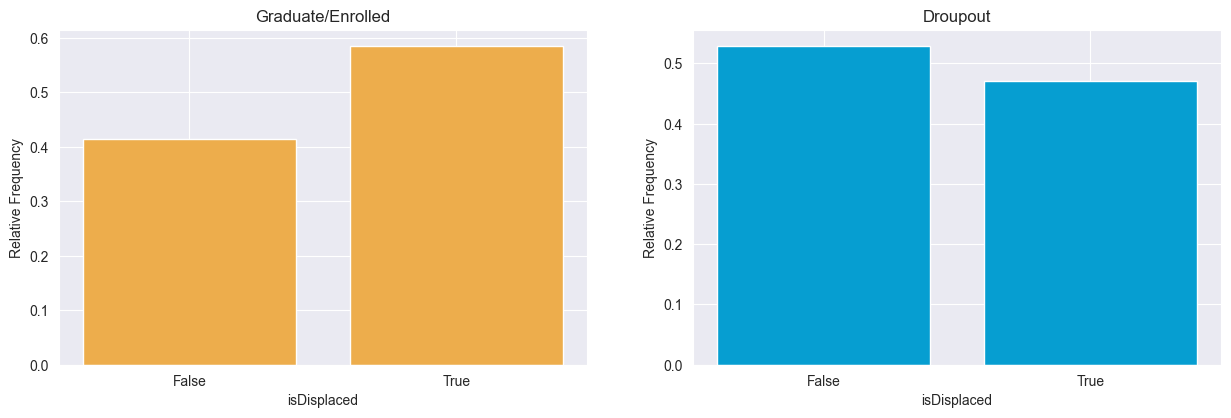

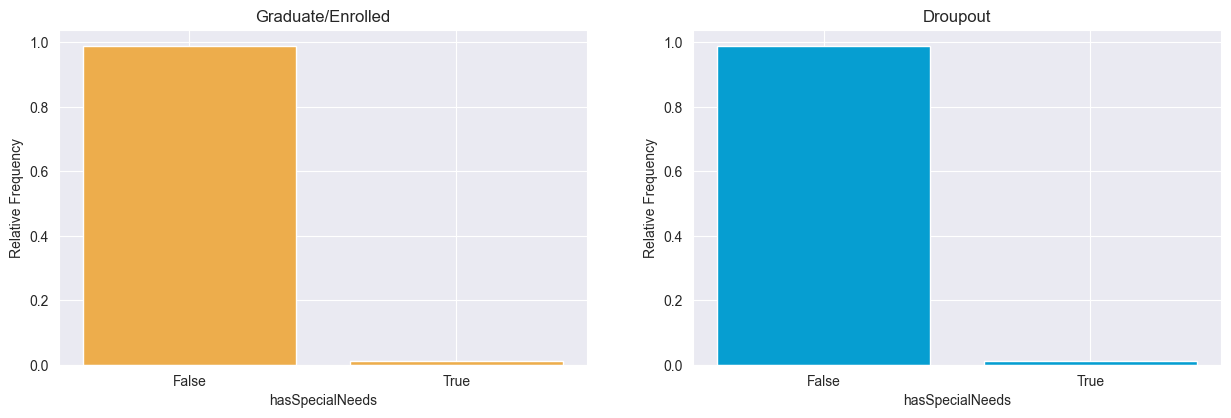

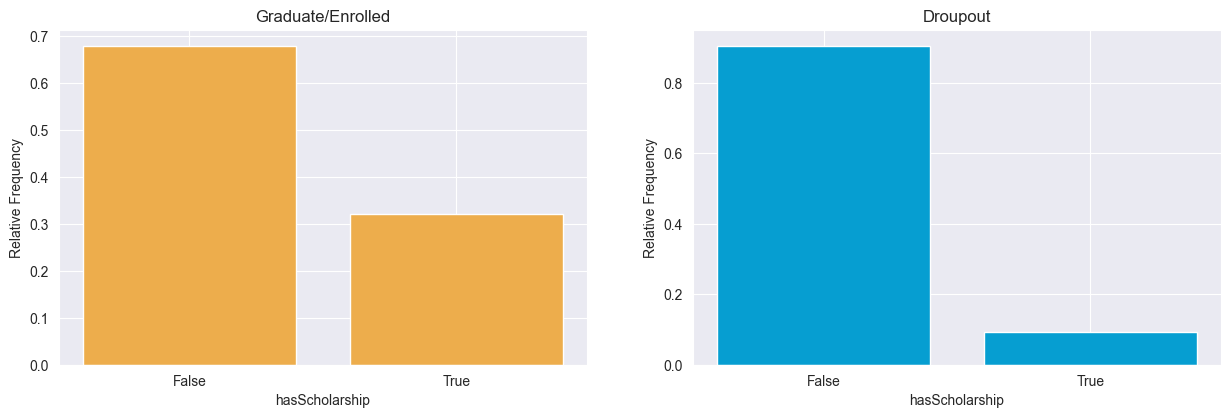

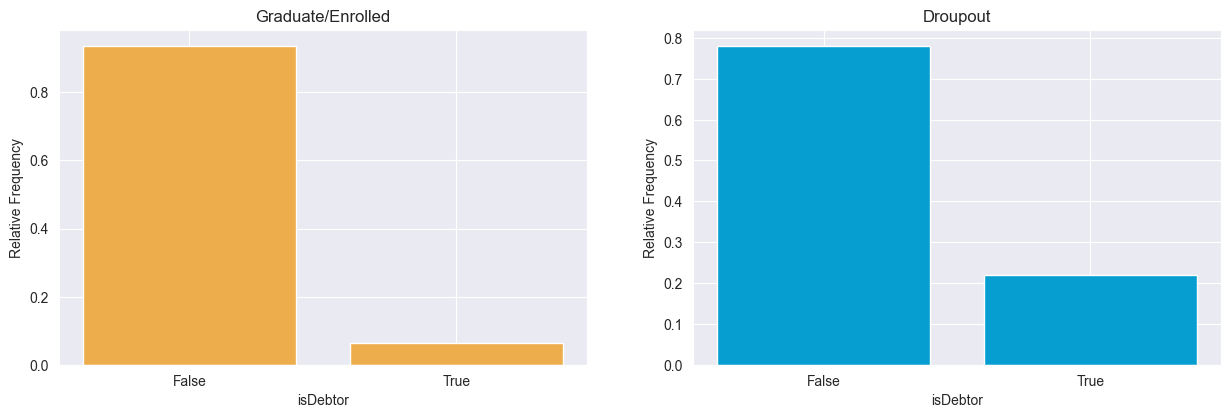

In [23]:
# features with boolean types
cols = ['isDisplaced', 'hasSpecialNeeds', 'hasScholarship', 'isDebtor']

pos = 1
for col in cols:
    plt.figure(figsize=(15,20))
    
    #creating DF with col, relative frequency for GRADUATE/ENROLLED
    grad_relfreq = df1_grad.groupby(col).count().reset_index()
    grad_relfreq = grad_relfreq.assign(Relative_Frequency = grad_relfreq.get('Course') / df1_grad.shape[0])
    grad_relfreq = grad_relfreq[[col, 'Relative_Frequency']]
    #convert bool val to String object
    grad_relfreq[col] = grad_relfreq.get(col).astype(str)

    #plot
    plt.subplot(4,2,pos)
    plt.bar(data=grad_relfreq, x=col, height='Relative_Frequency', color='#edad4c')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title('Graduate/Enrolled')

    #increment 
    pos += 1

    #creating DF with col, relative frequency for DROPOut
    drop_relfreq = df1_drop.groupby(col).count().reset_index()
    drop_relfreq = drop_relfreq.assign(Relative_Frequency = drop_relfreq.get('Course') / df1_drop.shape[0])
    drop_relfreq = drop_relfreq[[col, 'Relative_Frequency']]
    drop_relfreq[col] = drop_relfreq.get(col).astype(str)

    #plot
    plt.subplot(4,2,pos)
    plt.bar(data=drop_relfreq, x=col, height='Relative_Frequency', color='#069ed1')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title('Droupout')
    
    plt.show()

    #increment 
    pos += 1

> ### Key Observations
- A **larger proportion** of dropout students were **not displaced** compared to graduate/enrolled students.
- A **smaller proprotion** of dropout students **had a scholarship**.
- A **larger proportion** of dropout students **were debtors**. 

In [24]:
# storing relative frequencies 

    #isDisplaced
displaced = pd.crosstab(df1['Target'], df1['isDisplaced'])
displaced_relfreq_drop = displaced.loc['Dropout'] / df1_drop.shape[0]
displaced_relfreq_grad = displaced.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #hasScholarship
hasScholarship = pd.crosstab(df1['Target'], df1['hasScholarship'])
hasScholarship_relfreq_drop = hasScholarship.loc['Dropout'] / df1_drop.shape[0]
hasScholarship_relfreq_grad = hasScholarship.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #isDebtor
isDebtor = pd.crosstab(df1['Target'], df1['isDebtor'])
isDebtor_relfreq_drop = isDebtor.loc['Dropout'] / df1_drop.shape[0]
isDebtor_relfreq_grad = isDebtor.loc['Graduate/Enrolled'] / df1_grad.shape[0]

### Student Academic Path: Course
> `Course` here supposedly represents the the undergraduate degree each student was enrolled in

In [25]:
df1['Course'].value_counts()

Nursing                                 766
Management                              380
Social Service                          355
Veterinary Nursing                      337
Journalism and Communication            331
Advertising and Marketing Management    268
Management (evening attendance)         268
Tourism                                 252
Communication Design                    226
Animation and Multimedia Design         215
Social Service (evening attendance)     215
Agronomy                                210
Basic Education                         192
Informatics Engineering                 170
Equinculture                            141
Oral Hygiene                             86
Biofuel Production Technologies          12
Name: Course, dtype: int64

In [26]:
course_relfreq = pd.crosstab(df1['Target'], df1['Course'])
course_relfreq.loc['Dropout'] = (course_relfreq.loc['Dropout'] / df1_drop.shape[0])
course_relfreq.loc['Graduate/Enrolled'] = (course_relfreq.loc['Graduate/Enrolled'] / df1_grad.shape[0])
course_relfreq

Course,Advertising and Marketing Management,Agronomy,Animation and Multimedia Design,Basic Education,Biofuel Production Technologies,Communication Design,Equinculture,Informatics Engineering,Journalism and Communication,Management,Management (evening attendance),Nursing,Oral Hygiene,Social Service,Social Service (evening attendance),Tourism,Veterinary Nursing
Target,,,,,,,,,,,,,,,,,
Dropout,0.066854,0.060521,0.057706,0.059817,0.005630,0.035890,0.054891,0.064743,0.071077,0.094300,0.095707,0.083040,0.023223,0.045742,0.049965,0.067558,0.063336
Graduate/Enrolled,0.057609,0.041292,0.044289,0.035631,0.001332,0.058275,0.020979,0.025974,0.076590,0.081918,0.043956,0.215784,0.017649,0.096570,0.047952,0.051948,0.082251


##### We will perform a chi-square test for each sample (dropout, and graduate/enrolled) to investigate if the courses enrolled for each sample are uniformly representative.

> #### Comparing Relative Frequencies for Each Course

In [27]:
index = [col for col in course_relfreq.columns]
dropouts = course_relfreq.loc['Dropout'].values
grads = course_relfreq.loc['Graduate/Enrolled'].values

# df with relative frequencies of each target
plot_course_relfreq = pd.DataFrame({'Dropout': dropouts, 'Graduate/Enrolled': grads}, index=index)

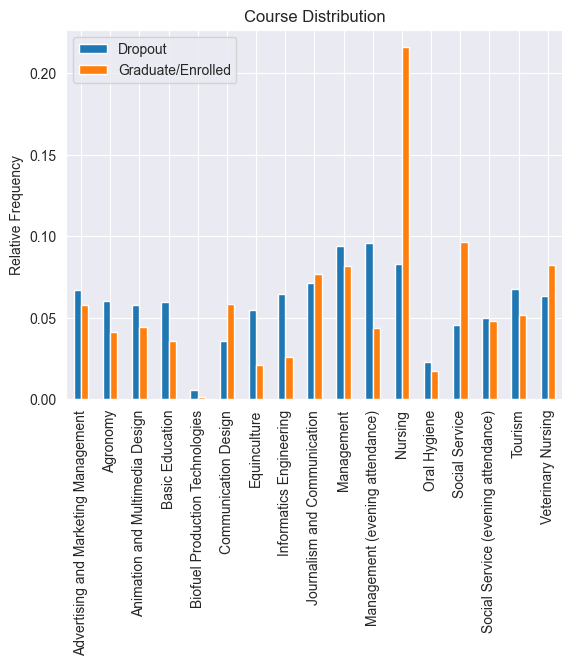

In [28]:
# plot
plot_course_relfreq.plot(kind='bar')
plt.ylabel('Relative Frequency')
plt.title('Course Distribution')
plt.show()

By observation,
- A larger proportion of **dropout students** were enrolled in **Equinculture, Informatics Engineering, Management**
- A larger proportion of **graduate/enrolled** students were enrolled in **Nursing, Social Service, Communication Design**

### Quantitative data: Identifying Correlations

In [29]:
# keep just the quantitative data for heatmap

cols = ['Admission grade', 'Age at enrollment', 'Previous qualification (grade)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)', 'Target']

df1_quant = df1[cols]
df1_quant.head()

,Admission grade,Age at enrollment,Previous qualification (grade),Unemployment rate,Inflation rate,GDP,Curricular units 2nd sem (grade),Curricular units 1st sem (grade),Target
0,127.3,20,122.0,10.8,1.4,1.74,0.000000,0.000000,Dropout
1,142.5,19,160.0,13.9,-0.3,0.79,13.666667,14.000000,Graduate/Enrolled
2,124.8,19,122.0,10.8,1.4,1.74,0.000000,0.000000,Dropout
3,119.6,20,122.0,9.4,-0.8,-3.12,12.400000,13.428571,Graduate/Enrolled
4,141.5,45,100.0,13.9,-0.3,0.79,13.000000,12.333333,Graduate/Enrolled


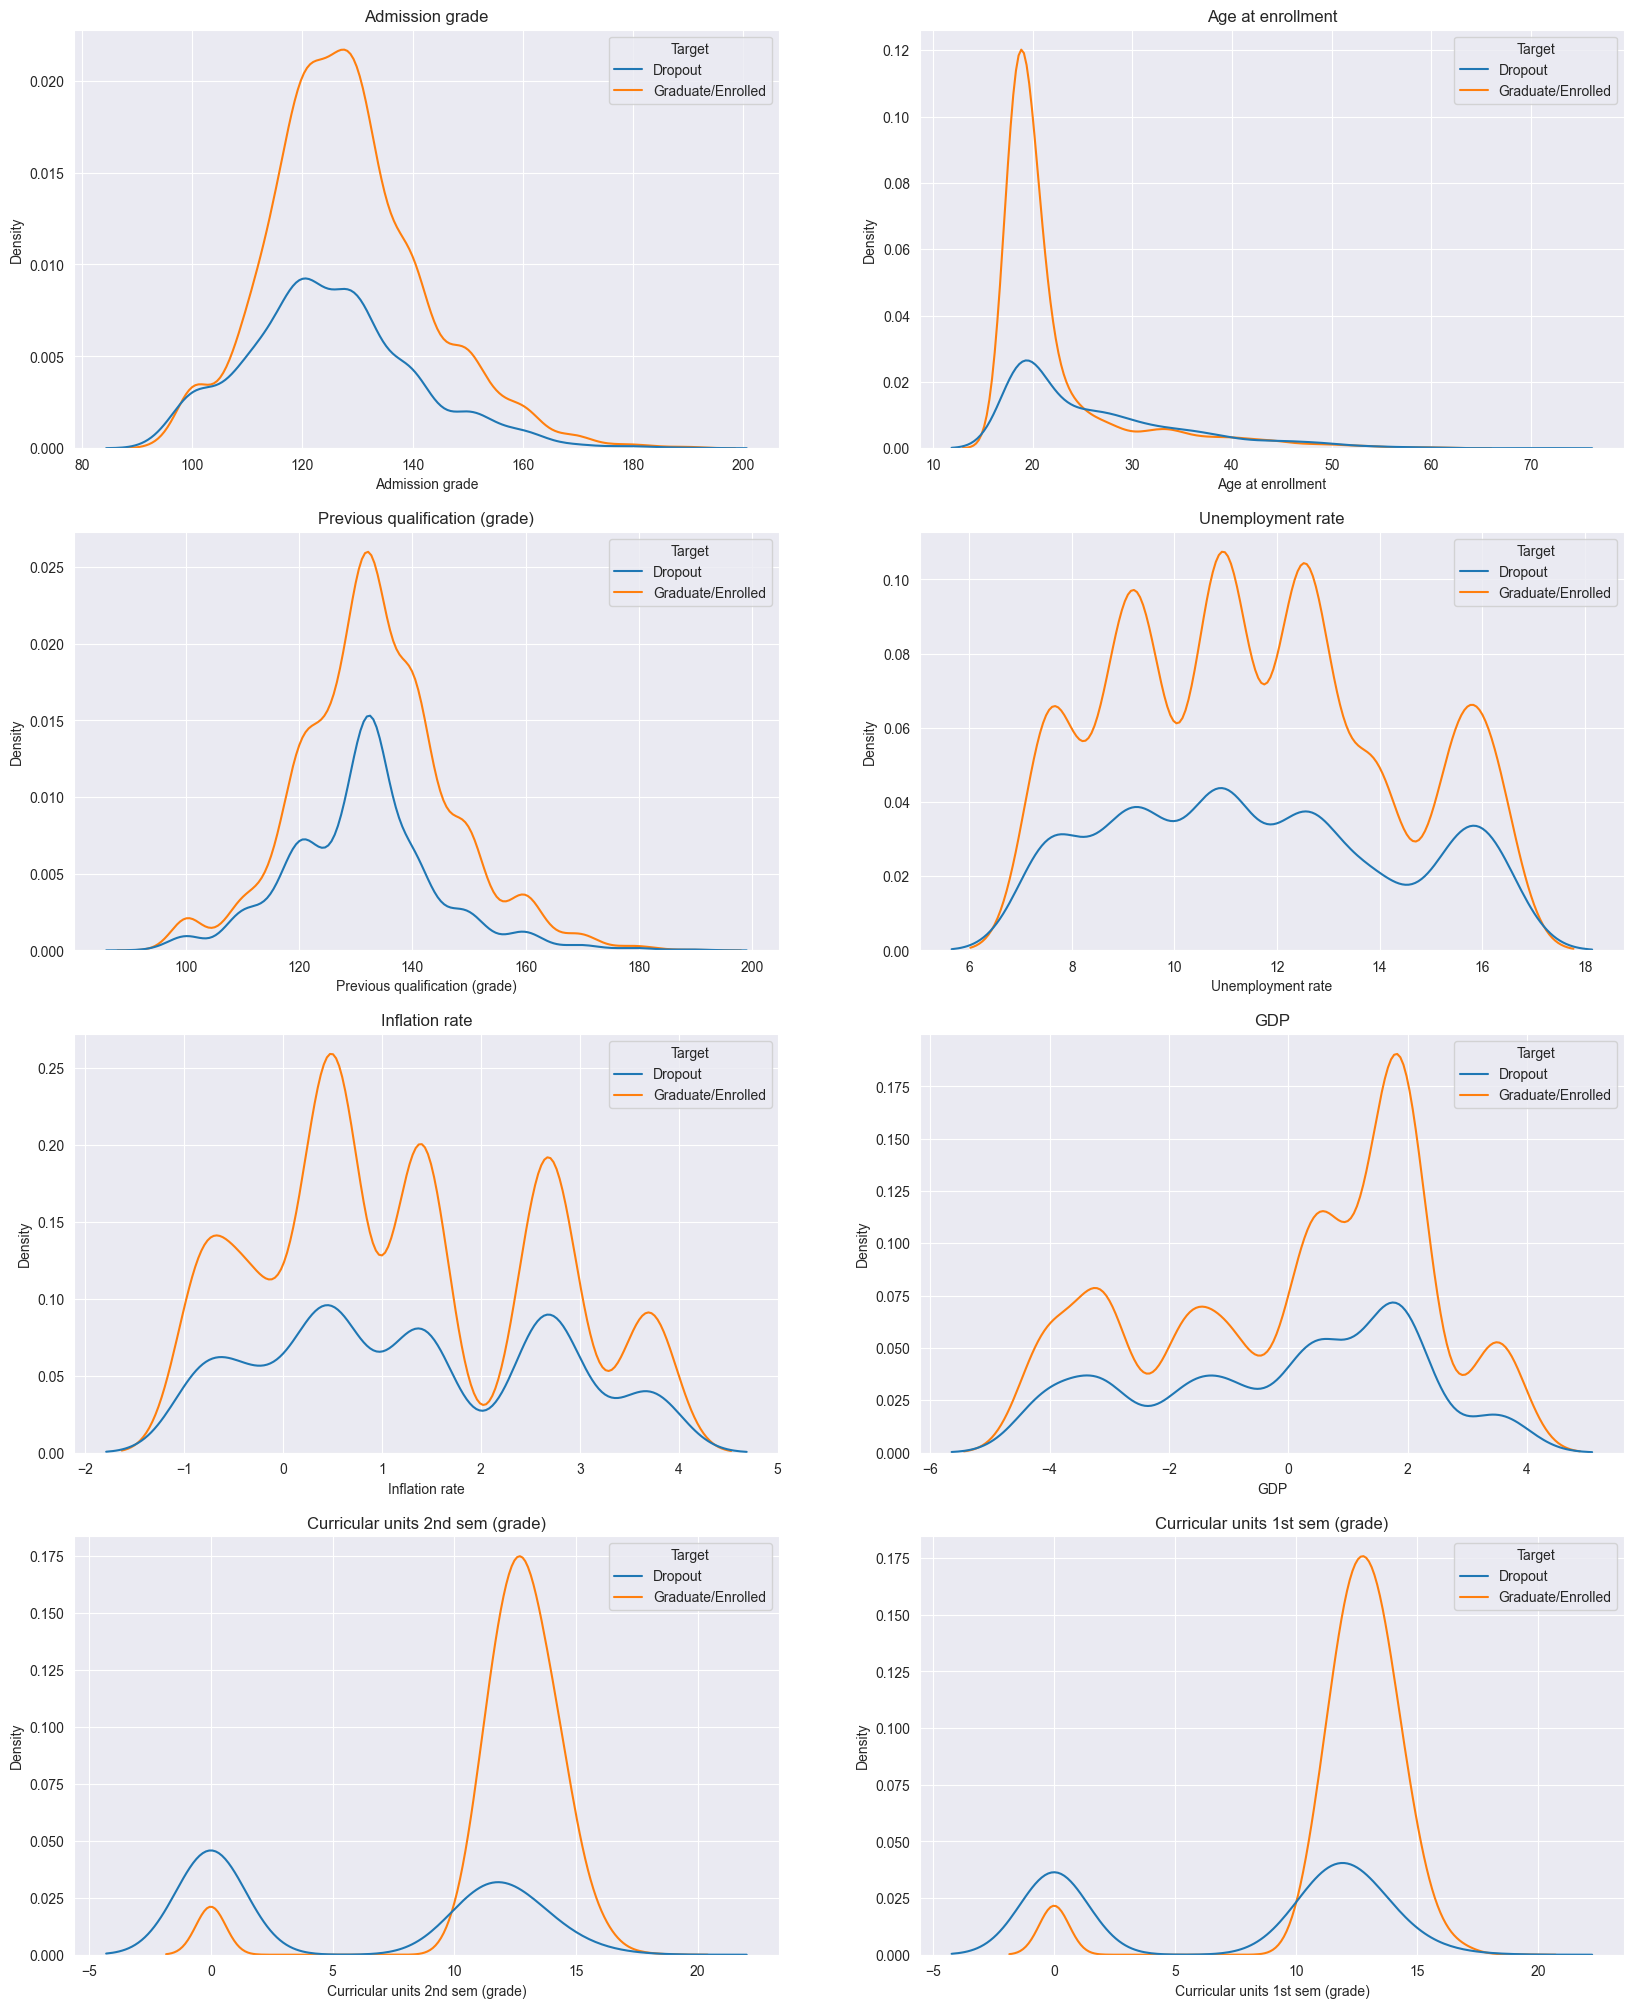

In [30]:
pos = 1
plt.figure(figsize=(20,25))
for col in cols:
    if col != 'Target':
        plt.subplot(4,2,pos)
        sns.kdeplot(data=df1_quant, x=col, hue='Target')
        plt.title(f"{col}")
        pos += 1

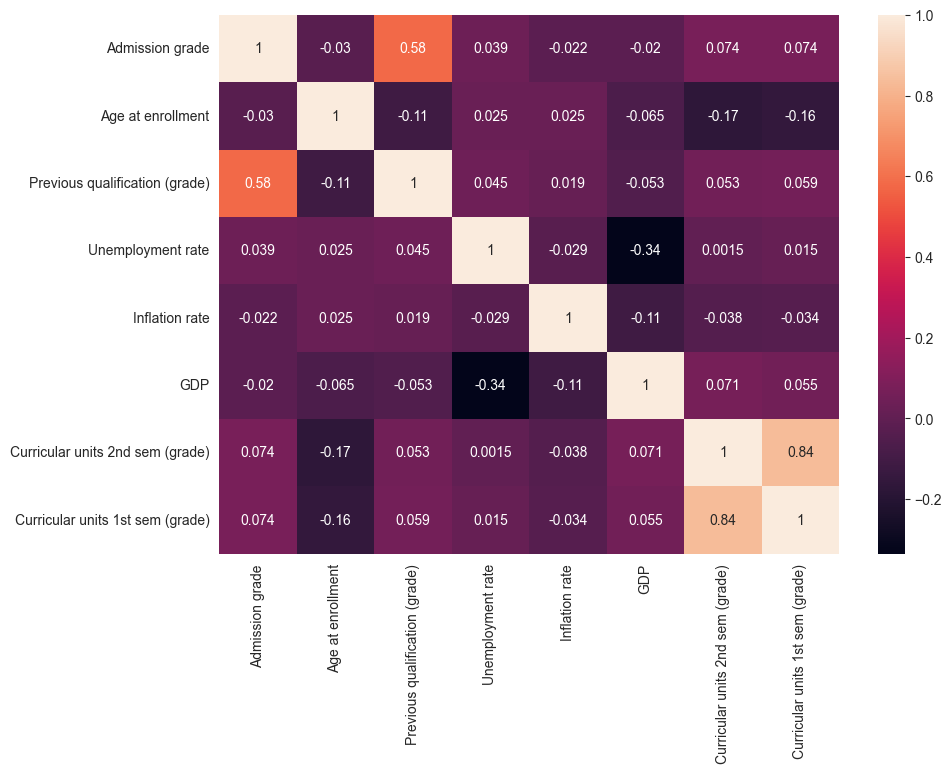

In [31]:
corr_matrix = df1_quant.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

> #### Quantitative data and the target variable

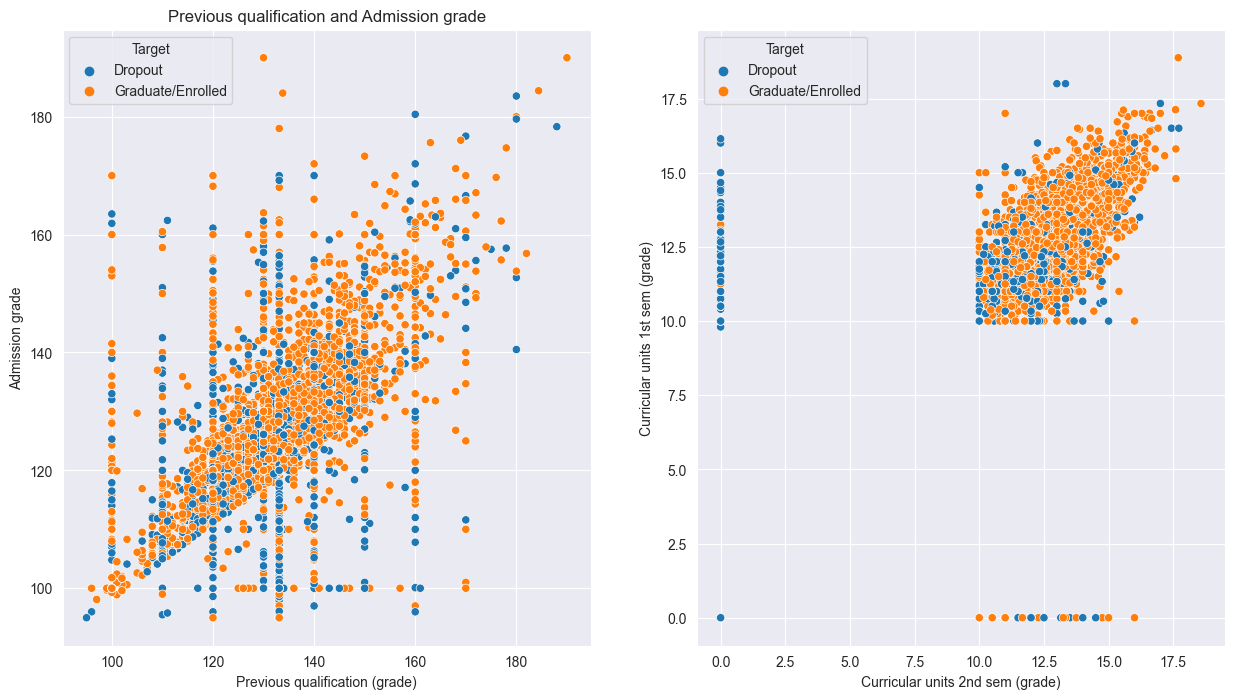

In [32]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
sns.scatterplot(data=df1, x='Previous qualification (grade)', y='Admission grade', hue='Target')
plt.title('Previous qualification and Admission grade')

plt.subplot(1,2,2)
sns.scatterplot(data=df1, x='Curricular units 2nd sem (grade)', y='Curricular units 1st sem (grade)', hue='Target')

plt.show()

##### Collection Bias: Nationality Distribution

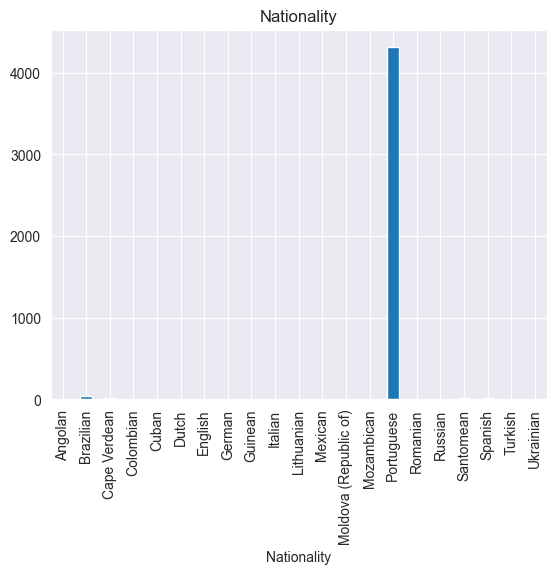

In [33]:
df1.groupby('Nationality').count().get('Marital Status').plot(kind='bar')
plt.title('Nationality')
plt.show()

### Hypothesis Testing (Leena)

The objective here is to determine whether our observed differences between dropout students and those who graduated or are still enrolled are statistically significant

##### Storing relative frequencies for desired features

In [35]:
    #marital_status
marital_status = pd.crosstab(df1['Target'], df1['Marital Status'])
marital_status_relfreq_drop = marital_status.loc['Dropout'] / df1_drop.shape[0]
marital_status_relfreq_grad = marital_status.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #previous qualification
prev_qual = pd.crosstab(df1['Target'], df1['Previous qualification'])
prev_qual_relfreq_drop = prev_qual.loc['Dropout'] / df1_drop.shape[0]
prev_qual_relfreq_grad = prev_qual.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #isDisplaced
displaced = pd.crosstab(df1['Target'], df1['isDisplaced'])
displaced_relfreq_drop = displaced.loc['Dropout'] / df1_drop.shape[0]
displaced_relfreq_grad = displaced.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #hasScholarship
hasScholarship = pd.crosstab(df1['Target'], df1['hasScholarship'])
hasScholarship_relfreq_drop = hasScholarship.loc['Dropout'] / df1_drop.shape[0]
hasScholarship_relfreq_grad = hasScholarship.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #isDebtor
isDebtor = pd.crosstab(df1['Target'], df1['isDebtor'])
isDebtor_relfreq_drop = isDebtor.loc['Dropout'] / df1_drop.shape[0]
isDebtor_relfreq_grad = isDebtor.loc['Graduate/Enrolled'] / df1_grad.shape[0]

### Methodology 
First, we will assume that dropout students graduate students both follow a **normal distribution**

For each question, we ran a **2 sample proportion test** with 2 different methods:
1. Performing permutation test using simulation: here we generated difference of proportions to calculated the p-value. 
2. Using the `statsmodels` module to generate p-value. 

> #### Marital Status
>
> Were more dropout students married (or once married) than students who graduated?

Let $\theta$ = The difference between the proportion of married/divorced dropout students with graduated/enrolled students

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta > 0$
> _The difference could not have occured from chance alone, and the students came from a different population._

In [36]:
# calculating sample statistic 
sample_stat = (marital_status_relfreq_drop['Divorced'] + marital_status_relfreq_drop['Married']) - (marital_status_relfreq_grad['Divorced'] + marital_status_relfreq_grad['Married'])
sample_stat

0.07260719575990511

> ##### Running the simulation

In [37]:
def marital_diff_in_prop(shuffled_df):
    freq_table = pd.crosstab(shuffled_df['Shuffled'], shuffled_df['Marital Status'])
    
    drop_rel_freq = freq_table.loc['Dropout'] / df1_drop.shape[0]
    grad_rel_freq = freq_table.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    drop_prop = drop_rel_freq['Married'] + drop_rel_freq['Divorced']
    grad_prop = grad_rel_freq['Married'] + grad_rel_freq['Divorced']

    return (drop_prop - grad_prop)

In [38]:
marital_df = df1[['Marital Status', 'Target']]
simulated_diffs = np.array([])
n = 500

for i in range(n):
    shuffled_target = np.random.permutation(marital_df.get('Target'))
    with_shuffled = marital_df.assign(Shuffled=shuffled_target)
    stat = marital_diff_in_prop(with_shuffled)
    simulated_diffs = np.append(simulated_diffs, stat)

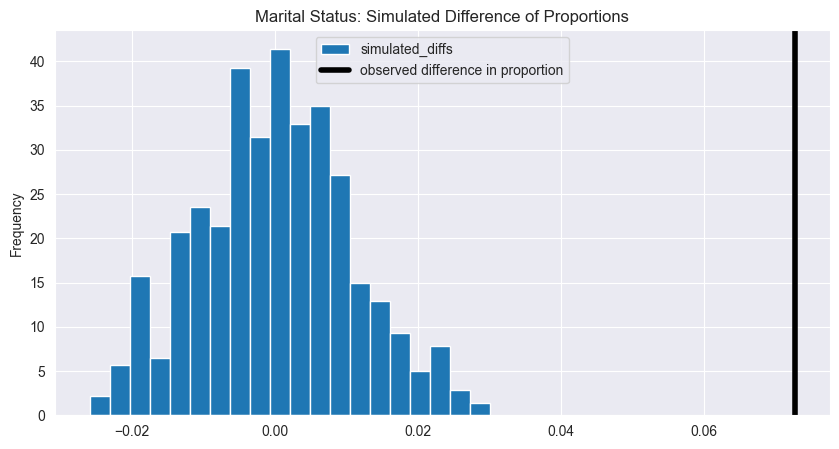

In [39]:
sns.set_style('darkgrid')

(pd.DataFrame()
 .assign(simulated_diffs=simulated_diffs)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(sample_stat, color='black', linewidth=4, label='observed difference in proportion')
plt.title('Marital Status: Simulated Difference of Proportions')
plt.legend();

In [40]:
marital_pval = np.count_nonzero(simulated_diffs >= sample_stat) / n
marital_pval

0.0

In [41]:
marital_status 

Marital Status,Divorced,Facto Union,Legally Separated,Married,Single,Widower
Target,,,,,,
Dropout,42,11,4,179,1184,1
Graduate/Enrolled,49,14,2,200,2735,3


In [42]:
# using statsmodel to perform test 
statsmodels.stats.proportion.proportions_ztest(
    count = [
        df1_drop['Marital Status'].map(lambda x: (x == 'Married') or (x == 'Divorced')).sum() ,
        df1_grad['Marital Status'].map(lambda x: (x == 'Married') or (x == 'Divorced')).sum() 
    ],
    nobs = [
        df1_drop.shape[0],
        df1_grad.shape[0]
    ],
    value = 0.0,
    alternative = 'larger'
)

(7.318038104297261, 1.258112121720764e-13)

> Both by simulation and the z-test resulted in a sufficiently small p-value, thus we reject the null. There is sufficient evidence to conclude that a **larger proportion** of **dropout students** were **married or divorced**

> ### Previous Qualification
>
> Has more dropout students not completed high school as opposed to those who have graduated/are enrolled?
>
> _In other words, do most students dropout after completing high school?_

Let $\theta$ = The difference between the proportion of dropout students who did not complete high school with graduated/enrolled students who did not complete high school.

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta > 0$
> _The difference could not have occured from chance alone, and the students came from a different population._

In [43]:
prev_qual

Previous qualification,Below secondary,Higher,Secondary
Target,,,
Dropout,149,194,1078
Graduate/Enrolled,83,281,2639


In [44]:
#computing observed stat
sample_stat = prev_qual_relfreq_drop['Below secondary'] - prev_qual_relfreq_grad['Below secondary'] 
sample_stat

0.07721670775857967

##### Running Simulation 

In [45]:
def prev_qual_diff_in_prop(shuffled_df):
    freq_table = pd.crosstab(shuffled_df['Shuffled'], shuffled_df['Previous qualification'])
    
    drop_rel_freq = freq_table.loc['Dropout'] / df1_drop.shape[0]
    grad_rel_freq = freq_table.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    drop_prop = drop_rel_freq['Below secondary'] 
    grad_prop = grad_rel_freq['Below secondary'] 
    
    return (drop_prop - grad_prop)

In [46]:
prev_qual_df = df1[['Target', 'Previous qualification']]
n = 500
simulated_diffs = np.array([])

for i in range(n):
    shuffled_target = np.random.permutation(prev_qual_df.get('Target'))
    with_shuffled = prev_qual_df.assign(Shuffled=shuffled_target)
    stat = prev_qual_diff_in_prop(with_shuffled)
    simulated_diffs = np.append(simulated_diffs, stat)

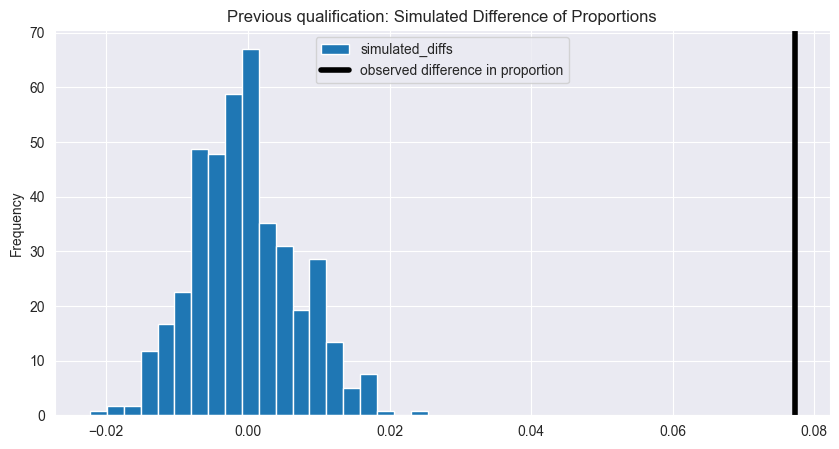

In [47]:
(pd.DataFrame()
 .assign(simulated_diffs=simulated_diffs)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(sample_stat, color='black', linewidth=4, label='observed difference in proportion')
plt.title('Previous qualification: Simulated Difference of Proportions')
plt.legend();

In [ ]:
prev_qual_pval = np.count_nonzero(simulated_diffs >= sample_stat) / n
prev_qual_pval

In [48]:
# using statsmodels to perform test 
statsmodels.stats.proportion.proportions_ztest(
    count = [
        df1_drop['Previous qualification'].map(lambda x: (x == 'Below secondary')).sum(),
        df1_grad['Previous qualification'].map(lambda x: (x == 'Below secondary')).sum() 
    ],
    nobs = [
        df1_drop.shape[0],
        df1_grad.shape[0]
    ],
    value = 0.0,
    alternative = 'larger'
)

(10.758182708244705, 2.7114504223121325e-27)

> Both by simulation and the z-test resulted in a sufficiently small p-value, thus we reject the null. There is sufficient evidence to conclude that a **larger proportion** of **dropout students** were **did not complete high school**.

### Hypothesis Testing for Binary Data

In [50]:
def diff_prop(shuffled_df, col):
    """
    Given shuffled column named 'Shuffled' of the target, returns difference between proportion
    of dropout students with gradeuate/enrolled students for desired column
    """
    freq_table = pd.crosstab(shuffled_df['Shuffled'], shuffled_df[col])
    
    drop_rel_freq = freq_table.loc['Dropout'] / df1_drop.shape[0]
    grad_rel_freq = freq_table.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    drop_prop = drop_rel_freq[True]
    grad_prop = grad_rel_freq[True]

    return (drop_prop - grad_prop)

> ### Displace
>
> Do graduate/enrolled students have a larger proportion of displaced students compared to dropout students?

Let $\theta$ = The difference between the proportion of dropout students who were displaced with graduated/enrolled students who did not complete high school.

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta < 0$
> _The difference could not have occured from chance alone._

##### Running Simulation 

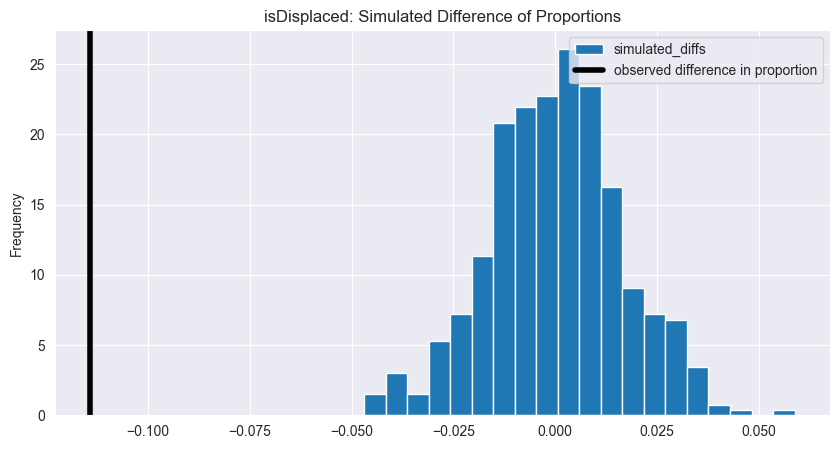

In [51]:
displaced_df = df1[['Target','isDisplaced']]
n = 500 
simulated_diffs = np.array([])

sample_stat = displaced_relfreq_drop[True] - displaced_relfreq_grad[True]

for i in range(n):
    shuffled_target = np.random.permutation(displaced_df['Target'])
    with_shuffled = displaced_df.assign(Shuffled=shuffled_target)
    stat = diff_prop(with_shuffled, 'isDisplaced') 
    simulated_diffs = np.append(simulated_diffs, stat)

# plotting simulated diffs and observed stat
(pd.DataFrame()
 .assign(simulated_diffs=simulated_diffs)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(sample_stat, color='black', linewidth=4, label='observed difference in proportion')
plt.title('isDisplaced: Simulated Difference of Proportions')
plt.legend();

In [52]:
isDisplaced_pval = np.count_nonzero(simulated_diffs <= sample_stat) / n
isDisplaced_pval

0.0

In [53]:
# using statsmodel to perform test 
statsmodels.stats.proportion.proportions_ztest(
    count = [
        df1_drop['isDisplaced'].map(lambda x: (x == True)).sum(),
        df1_grad['isDisplaced'].map(lambda x: (x == True)).sum() 
    ],
    nobs = [
        df1_drop.shape[0],
        df1_grad.shape[0]
    ],
    value = 0.0,
    alternative = 'smaller'
)

(-7.132365069915034, 4.932938815203346e-13)

> Both by simulation and the z-test resulted in a sufficiently small p-value, thus we reject the null. There is sufficient evidence to conclude that a **smaller proportion** of **dropout students** were **displaced**.

> ### hasScholarship
> 
> Do dropout students have a smaller proportion of scholarship recipients compared to graduated/enrolled students?

Let $\theta$ = The difference between the proportion of dropout students who had a scholarship with graduated/enrolled students who had a scholarship. 

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta < 0$
> _The difference could not have occured from chance alone._

##### Running Simulation

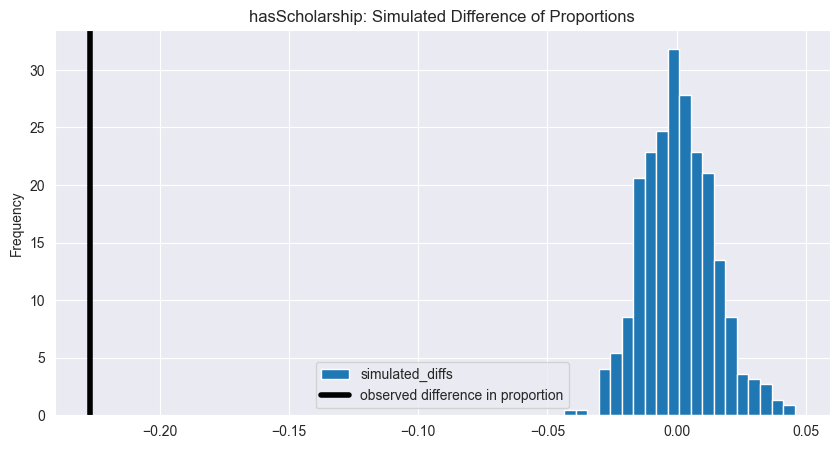

In [54]:
hasScholarship_df = df1[['Target','hasScholarship']]
n = 500 
simulated_diffs = np.array([])

sample_stat = hasScholarship_relfreq_drop[True] - hasScholarship_relfreq_grad[True] 

for i in range(n):
    shuffled_target = np.random.permutation(hasScholarship_df['Target']) 
    with_shuffled = hasScholarship_df.assign(Shuffled=shuffled_target) 
    stat = diff_prop(with_shuffled, 'hasScholarship') 
    simulated_diffs = np.append(simulated_diffs, stat) 

# plotting simulated diffs
(pd.DataFrame()
 .assign(simulated_diffs=simulated_diffs)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(sample_stat, color='black', linewidth=4, label='observed difference in proportion')
plt.title('hasScholarship: Simulated Difference of Proportions')
plt.legend();

In [ ]:
# calculate p-val 
hasScholarship_pval = np.count_nonzero(simulated_diffs <= sample_stat) / n
hasScholarship_pval

In [ ]:
# using statsmodels to perform test 
statsmodels.stats.proportion.proportions_ztest(
    count = [
        df1_drop['hasScholarship'].map(lambda x: (x == True)).sum(),
        df1_grad['hasScholarship'].map(lambda x: (x == True)).sum() 
    ],
    nobs = [
        df1_drop.shape[0],
        df1_grad.shape[0]
    ],
    value = 0.0,
    alternative = 'smaller'
)

> Both by simulation and the z-test resulted in a sufficiently small p-value, thus we reject the null. There is sufficient evidence to conclude that a **smaller proportion** of **dropout students** were **scholarship recipients**.

> ### Debtors
> 
> Do dropout students have a larger proportion of debtors compared to graduate/enrolled students?

Let $\theta$ = The difference between the proportion of dropout students who are debtors with graduated/enrolled debtors. 

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta > 0$
> _The difference could not have occured from chance alone._

##### Running Simulation

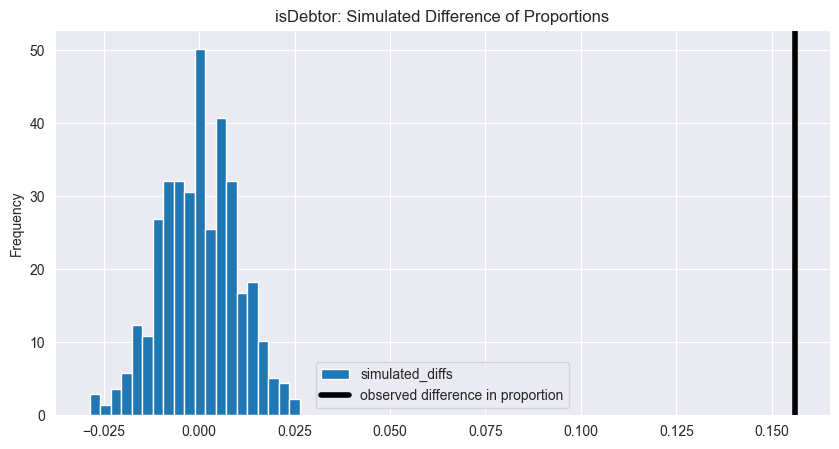

In [55]:
isDebtor_df = df1[['Target','isDebtor']]
n = 500
simulated_diffs = np.array([])

sample_stat = isDebtor_relfreq_drop[True] - isDebtor_relfreq_grad[True]

for i in range(n):
    shuffled_target = np.random.permutation(isDebtor_df['Target']) 
    with_shuffled = isDebtor_df.assign(Shuffled=shuffled_target)
    stat = diff_prop(with_shuffled, 'isDebtor') 
    simulated_diffs = np.append(simulated_diffs, stat) 

# plotting simulated diffs
(pd.DataFrame()
 .assign(simulated_diffs=simulated_diffs)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(sample_stat, color='black', linewidth=4, label='observed difference in proportion')
plt.title('isDebtor: Simulated Difference of Proportions')
plt.legend();

In [56]:
# calculating p-val 
isDebtor_pval = np.count_nonzero(simulated_diffs >= sample_stat) / n
isDebtor_pval

0.0

In [57]:
# using statsmodels to perform test 
statsmodels.stats.proportion.proportions_ztest(
    count = [
        df1_drop['isDebtor'].map(lambda x: (x == True)).sum(),
        df1_grad['isDebtor'].map(lambda x: (x == True)).sum() 
    ],
    nobs = [
        df1_drop.shape[0],
        df1_grad.shape[0]
    ],
    value = 0.0,
    alternative = 'larger'
)

(15.258604435495931, 7.215079900102946e-53)

> Both by simulation and the z-test resulted in a sufficiently small p-value, thus we reject the null. There is sufficient evidence to conclude that a **smaller proportion** of **dropout students** were **scholarship recipients**.

> ### Student Academic Path: Enrolled Courses

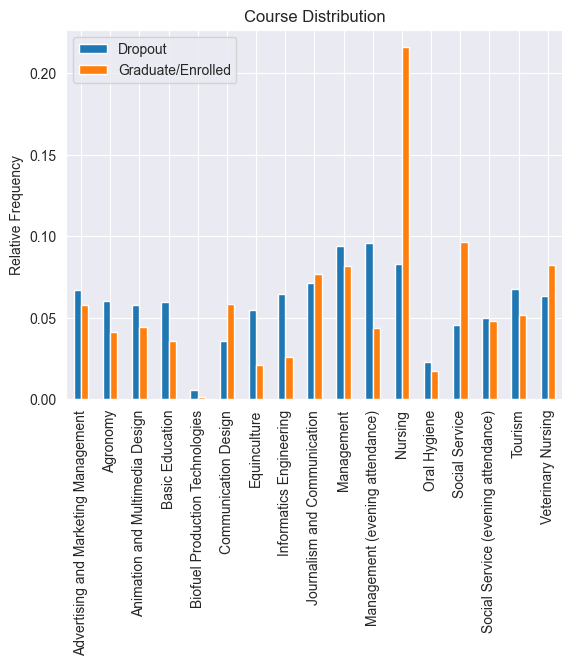

In [58]:
# df of relative frequencies
course_freq = pd.crosstab(df1['Target'], df1['Course'])

course_relfreq = pd.crosstab(df1['Target'], df1['Course'])
course_relfreq.loc['Dropout'] = (course_relfreq.loc['Dropout'] / df1_drop.shape[0])
course_relfreq.loc['Graduate/Enrolled'] = (course_relfreq.loc['Graduate/Enrolled'] / df1_grad.shape[0])

# creating df with relative frequencies of each target (to plot)
index = [col for col in course_relfreq.columns]
dropouts = course_relfreq.loc['Dropout'].values
grads = course_relfreq.loc['Graduate/Enrolled'].values

plot_course_relfreq = pd.DataFrame({'Dropout': dropouts, 'Graduate/Enrolled': grads}, index=index)

# plot
plot_course_relfreq.plot(kind='bar')
plt.ylabel('Relative Frequency')
plt.title('Course Distribution')
plt.show()

In [60]:
course_freq

Course,Advertising and Marketing Management,Agronomy,Animation and Multimedia Design,Basic Education,Biofuel Production Technologies,Communication Design,Equinculture,Informatics Engineering,Journalism and Communication,Management,Management (evening attendance),Nursing,Oral Hygiene,Social Service,Social Service (evening attendance),Tourism,Veterinary Nursing
Target,,,,,,,,,,,,,,,,,
Dropout,95,86,82,85,8,51,78,92,101,134,136,118,33,65,71,96,90
Graduate/Enrolled,173,124,133,107,4,175,63,78,230,246,132,648,53,290,144,156,247


In [61]:
# using statsmodels to perform test 
def course_two_prop_ztest(course, alternative):
    
    return (statsmodels.stats.proportion.proportions_ztest(
    count = [
        course_freq[course].loc['Dropout'],
        course_freq[course].loc['Graduate/Enrolled'] 
    ],
    nobs = [
        df1_drop.shape[0],
        df1_grad.shape[0]
    ],
    value = 0.0,
    alternative = alternative
    )
           )

##### 1. Were more dropout students enrolled in Equinculture, Informatics Engineering, and Management (evening attendance)?

Let $\theta$ = The difference between the proportion of dropout students who were enrolled in courses in question with graduated/enrolled debtors. 

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta > 0$
> _The difference could not have occured from chance alone._

In [62]:
courses = ['Equinculture', 'Informatics Engineering', 'Management (evening attendance)']
for course in courses:
    print(course)
    print('P-value: ' + str(course_two_prop_ztest(course, 'larger')[1]))
    print('\n')

Equinculture
P-value: 1.012115096367663e-09


Informatics Engineering
P-value: 1.8773131210977776e-10


Management (evening attendance)
P-value: 8.05779486213093e-12




> Since the P-values for all courses are small, we reject the null hypothesis. Thus, we have sufficient evidence to conclude that a larger proportion of dropout students were enrolled in Equinculture, Informatics Engineering, and Management (evening attendance).

##### Were less dropout students enrolled in Nursing, Social Service, and Communication Design?
Let $\theta$ = The difference between the proportion of dropout students who were enrolled in courses in question with graduated/enrolled debtors. 

$H_0$: $\theta = 0$
> _The distribution of dropout and graduated students came from the same distribution, so any difference is due to chance._

$H_a$: $\theta < 0$
> _The difference could not have occured from chance alone._

In [63]:
courses = ['Nursing', 'Social Service', 'Communication Design']
for course in courses:
    print(course)
    print('P-Value: ' + str(course_two_prop_ztest(course, 'smaller')[1]))
    print('\n')

Nursing
P-Value: 6.031490242155022e-28


Social Service
P-Value: 3.1116227467884122e-09


Communication Design
P-Value: 0.0007952947288784664




> All of the P-values are sufficiently small, so we reject the null hypothesis for all courses. Therefore, it could be said at a smaller proportion of dropout students were enrolled in nursing, social service, and communication design.
>
> Conversely, it could be said that a **larger proportion** of **graduate/enrolled** students were enrolled in **Nursing, Social Service,** and **Communication Design**.

> ### Key Takeaways

All of our hypothesis tests **rejects the null**, suggesting 
1. A larger proportion dropout students were married or were once married.
2. A larger proportion dropout students did not complete high school (that is, students tend to drop out before completing high school).
3. A larger proportion of graduate/enrolled students were displaced. 
4. A larger proportion of graduate/enrolled students were scholarship recipients.
5. A larger proportion of dropout students were debtors.
6. More dropout students were enrolled in Equinculture, Informatics Engineering, and Management.
7. More graduate/enrolled students were enrolled in Nursing, Social Service, and Communication Design.

### More Parametric Hypothesis Testing (Leena)

##### Student Academic Path: Chi-Squared Test
> Are the enrolled courses for both graduate/enrolled and dropout students **uniform**?

In [65]:
# observing relative frequencies of course for each target
course_relfreq = pd.crosstab(df1['Target'], df1['Course'])
course_relfreq.loc['Dropout'] = (course_relfreq.loc['Dropout'] / df1_drop.shape[0])
course_relfreq.loc['Graduate/Enrolled'] = (course_relfreq.loc['Graduate/Enrolled'] / df1_grad.shape[0])
course_relfreq

Course,Advertising and Marketing Management,Agronomy,Animation and Multimedia Design,Basic Education,Biofuel Production Technologies,Communication Design,Equinculture,Informatics Engineering,Journalism and Communication,Management,Management (evening attendance),Nursing,Oral Hygiene,Social Service,Social Service (evening attendance),Tourism,Veterinary Nursing
Target,,,,,,,,,,,,,,,,,
Dropout,0.066854,0.060521,0.057706,0.059817,0.005630,0.035890,0.054891,0.064743,0.071077,0.094300,0.095707,0.083040,0.023223,0.045742,0.049965,0.067558,0.063336
Graduate/Enrolled,0.057609,0.041292,0.044289,0.035631,0.001332,0.058275,0.020979,0.025974,0.076590,0.081918,0.043956,0.215784,0.017649,0.096570,0.047952,0.051948,0.082251


> $H_0$: The frequencies for each course are uniform, and any variance is due to chance.
>
> $H_a$: A uniform proportion for each course is **not** a good fit, suggesting a skewness of a particular course the students are enrolled in.

In [66]:
# graduate/enrolled
print('Graduate/Enrolled Students')
print('P-value: ' + str(stats.chisquare(df1_grad['Course'].value_counts())[1]))

# dropout
print('\nDropout')
print('P-value: ' + str(stats.chisquare(df1_drop['Course'].value_counts())[1]))

Graduate/Enrolled Students
P-value: 0.0

Dropout
P-value: 1.2302569950781588e-34


> Both tests resulted in a p-val of 0 (or close to 0), so we reject the null for both graduate/enrolled and dropout students. Thus, it could be said that there is some skewness of the distribution of Courses that each student is enrolled in. 

### Hypothesis Testing - Cross Checking (Mackenzie)

### Logistic Regression (Samuel)

In [3]:
# importing libraries
import plotly
import plotly.express as px
import plotly.graph_objects as go

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Random Forest Classifier (Krystal)

In [2]:
# importing libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix